In [1]:
#Loading libraries
import pymongo as pymongo
from pymongo import MongoClient
import pprint
import json
import csv
from textblob import TextBlob
import os
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.corpus import stopwords
import string
import nltk 
import textmining
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import joblib

In [ ]:
#install packages if required

# Database Connection

In [2]:
#saving the dataset in the database, we can also read csv file dirctly or can fetch the dataset from database(MongoDB)
def Database():
    # Connect to the MongoDB, change the connection string per your MongoDB environment
    Channel = MongoClient(port=27017)
    
    # Set the db object to point to the business database
    Select_db = Channel.SarcasmDetection
    
    # Set collection name
    Select_collection = Select_db.SarcasmHeadlinesDataset
    
    # Extract data from mongodb
    # Create json file
    cursor = Select_collection.find()
    
    # Convert json into pandas
    result = pd.DataFrame(list(cursor))
    
    return result

dataset = Database()

In [3]:
dataset

,_id,is_sarcastic,headline,article_link
0,60c9e0924a66d31b741e3788,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,60c9e0924a66d31b741e3789,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,60c9e0924a66d31b741e378a,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,60c9e0924a66d31b741e378b,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,60c9e0924a66d31b741e378c,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...,...
28614,60c9e0954a66d31b741ea74e,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,60c9e0954a66d31b741ea74f,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,60c9e0954a66d31b741ea750,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,60c9e0954a66d31b741ea751,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


### We do not need some columns in the above dataset, so we can drop the unnecessary columns from our dataset.

In [4]:
dataset = dataset.drop(['_id', 'article_link'], axis = 1)

In [5]:
#Checking is there is any null value
dataset.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [6]:
#Checking if there is any null values available in the dataset by counting all the values.
dataset.count()

is_sarcastic    28619
headline        28619
dtype: int64

# Pre-processing

In [7]:
#stop words and punctuations
stop = set(stopwords.words("english"))
exclude = set(string.punctuation)

#removing stop words, punctuations, numbers from our dataset
def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join([i for i in stop_free if i not in exclude])
    num_free = ''.join(i for i in punc_free if not i.isdigit())
    return (num_free)

post_corpus = [clean(dataset.iloc[i,1]) for i in range(0, dataset.shape[0])]

In [8]:
post_corpus

['thirtysomething scientists unveil doomsday clock hair loss',
 'dem rep totally nails congress falling short gender racial equality',
 'eat veggies  deliciously different recipes',
 'inclement weather prevents liar getting work',
 'mother comes pretty close using word streaming correctly',
 'white inheritance',
 ' ways file taxes less stress',
 'richard bransons globalwarming donation nearly much cost failed balloon trips',
 'shadow government getting large meet marriott conference room b',
 'lots parents know scenario',
 'lesbian considered father indiana and amazing one that',
 'amanda peet told daughter sex a special hug',
 'know regarding current treatments ebola',
 'chris christie suggests hillary clinton blame boko harams kidnapping hundreds schoolgirls',
 'ford develops new suv runs purely gasoline',
 'uber ceo travis kalanick stepping trump economic advisory council',
 'area boy enters jumpingandtouchingtopsofdoorways phase',
 'area man traveling gurney',
 'leave person disabi


# Visualization

In [9]:
#splitting sarcastic and not sarcastic headlines for visualizing wordcloud
sarcastic = []
notSarcastic = []
for i in range (0,len(dataset)):
    if dataset['is_sarcastic'][i] == 1:
        sarcastic.append(dataset['headline'][i])
    else:
        notSarcastic.append(dataset['headline'][i])

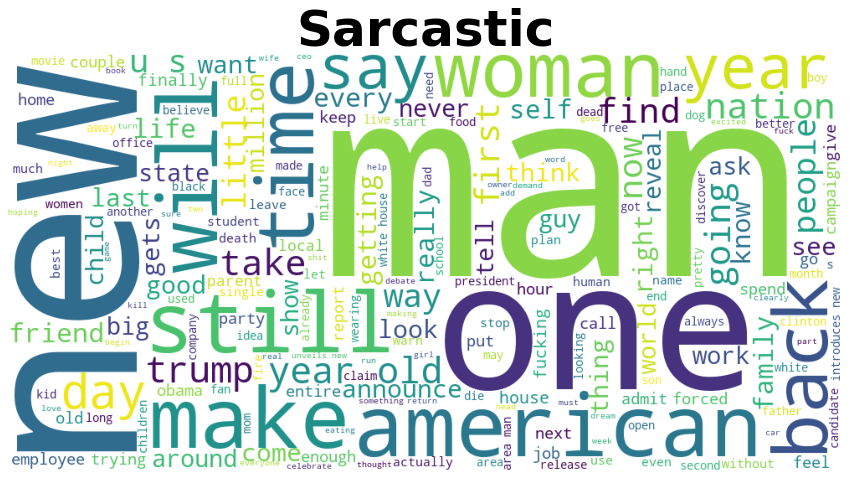

In [10]:
#Visualizing sarcastic headlines in wordcloud 
wordcloud_sarcastic = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(
                                ''.join(sarcastic))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud_sarcastic)
plt.axis('off')
plt.title("Sarcastic", fontsize = 50, fontweight='bold')
plt.show()

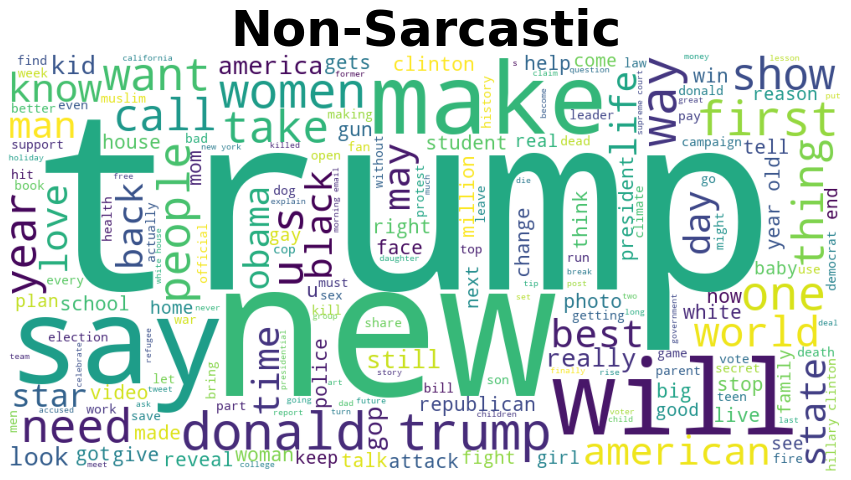

In [11]:
#Visualizing non-sarcastic headlines in wordcloud
wordcloud_notSarcastic = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(
                                ''.join(notSarcastic))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud_notSarcastic)
plt.axis('off')
plt.title("Non-Sarcastic", fontsize = 50, fontweight='bold')
plt.show()

### Creating Document Term Matrix

In [12]:
# Create document term matrix
tdm = textmining.TermDocumentMatrix()
for i in post_corpus:
        tdm.add_doc(i)

        
# Write tdm - saving matrix in csv format in system.
#tdm.write_csv("TDM_DataFRame.csv", cutoff = 1)

In [13]:
# Load dataframe from system.
df = pd.read_csv("TDM_DataFRame.csv")

In [14]:
df

,thirtysomething,scientists,unveil,doomsday,clock,hair,loss,dem,rep,totally,...,venetian,pok,progay,polack,antonios,dominant,rosh,hashasha,orbiting,spielberggates
0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
28615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


# Prediction

In [15]:
x = df
y = dataset['is_sarcastic']

In [16]:
#Splitting data
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify = y, test_size = 0.3, random_state = 101)

#Normalizing the values
y_train.value_counts(normalize = True)
y_test.value_counts(normalize = True)

0    0.523643
1    0.476357
Name: is_sarcastic, dtype: float64

# 1. Logistic Regression

In [17]:
def LR(dataset):
    
    #SAVING THE MODEL BECAUSE WE DO NOT NEED TO TRAIN THE MODEL AGAIN & AGAIN. SO, AFTER TRAINING SAVE THE MODEL.
    #TRAINING & PREDICTING
    #logmodel = LogisticRegression()
    #logmodel.fit(x_train, y_train)

    #joblib.dump(logmodel, 'lr.pkl')
    lr_model = joblib.load('lr.pkl')
    lr_predictions = lr_model.predict(x_test)
    return lr_predictions
    return dataset


lr_predictions = LR(dataset)

In [18]:
lr_predictions

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

## Checking Accuracy

Accuracy: 79 %

Confusion Matrix:
 [[3805  691]
 [1051 3039]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      4496
           1       0.81      0.74      0.78      4090

    accuracy                           0.80      8586
   macro avg       0.80      0.79      0.80      8586
weighted avg       0.80      0.80      0.80      8586

HeatMap:
 AxesSubplot(0.125,0.125;0.62x0.755)


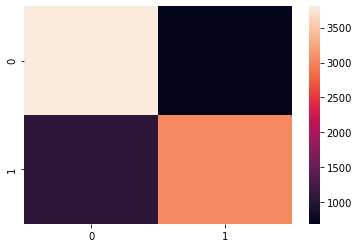

In [23]:
#ACCURACY
def LR_accuracy():
    accuracy = accuracy_score(y_test, lr_predictions)
    print("Accuracy:",int(accuracy*100),"%\n")
    
    #CONFUSION MATRIX
    print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions),"\n")
    print("Classification Report:\n",classification_report(y_test, lr_predictions))
    print("HeatMap:\n", sns.heatmap(confusion_matrix(y_test, lr_predictions)))
    
LR_accuracy()

# 2. Random Forest

In [24]:
def RF(dataset):
    
    #rf_model = RandomForestClassifier(n_estimators = 20).fit(x_train, y_train)
    #rf_predictions = RF_model.predict(x_test)
    
    #SAVING MODEL
    #joblib.dump(rf_model, 'rf.pkl')
    rf_model = joblib.load('rf.pkl')
    rf_predictions = rf_model.predict(x_test)
    return rf_predictions

rf_predictions = RF(dataset)

In [25]:
rf_predictions

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

## Checking Accuracy

Accuracy: 74 %

Confusion Matrix:
 [[3891  605]
 [1627 2463]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78      4496
           1       0.80      0.60      0.69      4090

    accuracy                           0.74      8586
   macro avg       0.75      0.73      0.73      8586
weighted avg       0.75      0.74      0.73      8586

HeatMap:
 AxesSubplot(0.125,0.125;0.62x0.755)


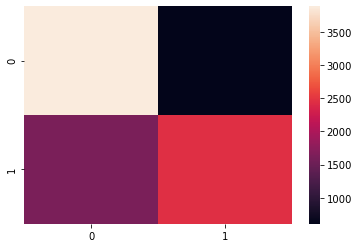

In [26]:
def RF_accuracy():
    #ACCURACY
    RF_accuracy = accuracy_score(y_test, rf_predictions)
    print("Accuracy:",int(RF_accuracy*100),"%\n")
    
    #CONFUSION MATRIX
    print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions),"\n")
    print("Classification Report:\n",classification_report(y_test, rf_predictions))
    print("HeatMap:\n", sns.heatmap(confusion_matrix(y_test, rf_predictions)))
    
RF_accuracy()

## After applying two algorithms: Logistic Regression & Random Forest, we got predictions from both of the algorithm and found that Logistic Regression is more accurate than Random Forest as:
## Logistic Regression: 79%
## Random Forest: 74%

# Prediction for single news headline - for Users

In [27]:
%run userPrediction.ipynb

Text: nation's older brothers recommend not being such a little bitch
Sarcasm is Present
